## This is an end to end example of using ArcGIS with R

(A shorter version of the similar one as in python but adapted to R) , the pyhton one has been mostly followed as a simplefied version from here https://github.com/orhuna/RF-Demo/blob/master/RF_Demo_Fl.ipynb 

For better visualization, maps have been published into the GIS server with a public read access to display it in the notebook cell



In [1]:
#It might show warning e.g. "*** Please call arc.check_product() to define a desktop license." but can be disregarded 
library(arcgisbinding)

*** Please call arc.check_product() to define a desktop license.


This should show sonme version info like:

license    'Advanced'
version    '12.1.0.10257'
path       'C:\\Program Files\\ArcGIS\\Pro\\'
dll        'rarcproxy_pro'
app        'ArcGIS Pro'
pkg_ver    '1.0.0.128'

Do not proceed if this fails, means the arcgisbindings is not working

In [2]:
arc.check_product()

product: ArcGIS Pro ( 12.1.0.10257 )
license: Advanced

In [3]:
inputDir <- arc.open(path = 'C:/GISDemo/SeaGrass/SeaGrass.gdb/FloridaSeaGrass')

In [4]:
analysis_map_URL <- 'https://services3.arcgis.com/oZfKvdlWHN1MwS48/ArcGIS/rest/services/MachineLearningSeagrass/FeatureServer/1&source=sd'

In [5]:
url <- paste('http://www.arcgis.com/home/webmap/viewer.html?url=',analysis_map_URL)
display_url<- paste('<iframe src=','"',url, '"','width=100%, height=500></iframe>')

In [6]:
IRdisplay::display_html(display_url)

In [7]:
#Names of Prediction Variables
predictVars <- c('salinity', 'temp', 'phosphate','nitrate', 
               'silicate', 'dissO2', 'NameEMU')
#Name of Classification Variable
classVar <- 'Present'
#List of all Variables
allVars <- c(predictVars , classVar)
allVars

[1] "salinity"  "temp"      "phosphate" "nitrate"   "silicate"  "dissO2"   
[7] "NameEMU"   "Present"

In [8]:
data <- arc.select(object = inputDir, fields = allVars)
head(data)

salinity,temp,phosphate,nitrate,silicate,dissO2,NameEMU,Present
35.69495,24.75329,0.07051622,0.5035413,3.878356,5.038187,"Epipelagic, Warm to Very Warm, Euhaline, Oxic, Low Nitrate, Low Phosphate, Low Silicate",0
35.98500,24.13740,0.12498700,0.8363543,1.521608,4.710738,"Epipelagic, Warm to Very Warm, Euhaline, Oxic, Low Nitrate, Low Phosphate, Low Silicate",0
35.58104,18.00565,1.03244400,15.1722698,10.742860,3.839985,"Epipelagic, Warm to Very Warm, Euhaline, Oxic, Low Nitrate, Low Phosphate, Low Silicate",1
35.46936,14.55408,0.93663418,14.1091700,9.925514,3.654587,"Epipelagic, Warm to Very Warm, Euhaline, Oxic, Low Nitrate, Low Phosphate, Low Silicate",1
35.41380,13.48950,0.98052150,14.7467203,10.737210,3.721700,"Epipelagic, Warm to Very Warm, Euhaline, Oxic, Low Nitrate, Low Phosphate, Low Silicate",0
35.74353,17.27345,0.47275189,6.9736042,5.724543,4.175582,"Epipelagic, Warm to Very Warm, Euhaline, Oxic, Low Nitrate, Low Phosphate, Low Silicate",0


Now you’ll convert your R data frame into a spatial data frame object using the arc.data2sp() function. A spatial data frame object is one of the spatial data classes contained in the sp package. The sp package offers classes and methods for working with spatial data such as points, lines, polygons, pixels, rings, and grids. With this function, you can transfer all of the spatial attributes from your data, including projections, from ArcGIS into R without worrying about a loss of information. If you've never used the sp package, you need to install the sp package into your RStudio package library, and load the functions from the sp package into your workspace environment.

In [10]:
library(sp)

ERROR: Error in library(sp): there is no package called 'sp'


Use the arc.data2sp() function. For the first argument, use the enrich_select_df data frame as the object you are converting to an sp object.

In [11]:
#This will be used to write back to the Arc GIS DB
data_sp <- arc.data2sp(data)

ERROR: Error in arc.data2sp.arc.data(data): This function requires the sp package.


In [44]:
#ignore any warning related to dummies package
install.packages("dummies")
library(dummies)
data<- dummy.data.frame(data_sp@data)
#head(data)
#Abbreviate Long Categorical Variable Names
newNames = c('c1','c2','c3')
names(data)[7:9]<-newNames
head(data)

Warning message:
"package 'dummies' is in use and will not be installed"

salinity,temp,phosphate,nitrate,silicate,dissO2,c1,c2,c3,Present0,Present1
35.69495,24.75329,0.07051622,0.5035413,3.878356,5.038187,0,1,0,1,0
35.98500,24.13740,0.12498700,0.8363543,1.521608,4.710738,0,1,0,1,0
35.58104,18.00565,1.03244400,15.1722698,10.742860,3.839985,0,1,0,0,1
35.46936,14.55408,0.93663418,14.1091700,9.925514,3.654587,0,1,0,0,1
35.41380,13.48950,0.98052150,14.7467203,10.737210,3.721700,0,1,0,1,0
35.74353,17.27345,0.47275189,6.9736042,5.724543,4.175582,0,1,0,1,0


In [28]:
# Get lower triangle of the correlation matrix
get_lower_tri<-function(cormat) {
     cormat[upper.tri(cormat)] <- NA
     return(cormat)
}
#
# Get upper triangle of the correlation matrix
get_upper_tri <- function(cormat) {
     cormat[lower.tri(cormat)] <- NA
     return(cormat)
}
#
reorder_cormat <- function(cormat) {
     # Use correlation between variables as distance
     dd <- as.dist((1-cormat) / 2)
     hc <- hclust(dd)
     cormat <- cormat [hc$order, hc$order]
}

In [29]:
#install.packages("reshape2")
library (reshape2)
#install.packages("ggplot2")
library (ggplot2)
#install.packages("ggmap")
library (ggmap)

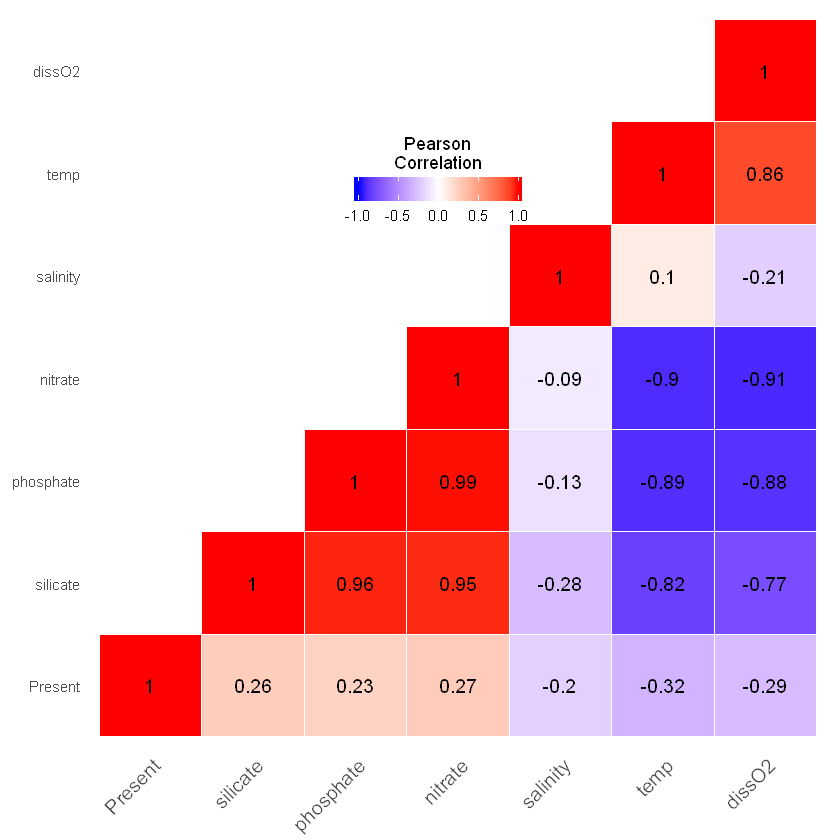

In [30]:
corr_sub <- data[ c('salinity', 'temp', 'phosphate', 'nitrate', 'silicate', 'dissO2' , 'Present')]
cormax <- round (cor(corr_sub), 2)
upper_tri <- get_upper_tri (cormax)
melted_cormax <- melt (upper_tri, na.rm = TRUE)
cormax <- reorder_cormat (cormax)
upper_tri <- get_upper_tri (cormax)
melted_cormax <- melt (upper_tri, na.rm = TRUE)
ggheatmap <- ggplot (melted_cormax, aes (Var2, Var1, fill = value)) +
     geom_tile(color = "white") +
     scale_fill_gradient2 (low = "blue", high = "red", mid = "white", midpoint = 0, limit = c(-1,1), space = "Lab", name = "Pearson\nCorrelation") +
     theme_minimal() + # minimal theme
     theme (axis.text.x = element_text(angle = 45, vjust = 1, size = 12, hjust = 1)) +
     coord_fixed()
#print (ggheatmap)
ggheatmap +
     geom_text (aes (Var2, Var1, label = value), color = "black", size = 4) +
     theme (
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          panel.grid.major = element_blank(),
          panel.border = element_blank(),
          axis.ticks = element_blank(),
          legend.justification = c (1, 0),
          legend.position = c (0.6, 0.7),
          legend.direction = "horizontal") +
     guides (fill = guide_colorbar (barwidth = 7, barheight = 1, title.position = "top", title.hjust = 0.5))

In [31]:
install.packages("caret")
install.packages("randomForest")
library(caret)
#Also convert Present to factor as it is integer type 
data$Present <-as.factor(data$Present)

##PERFORM RANDOM FOREST CLASSIFICATION
trainIndex = createDataPartition(data$Present, 
                       p=0.7, list=FALSE,times=1)
 
train = data[trainIndex,]
test = data[-trainIndex,]

In [11]:
nrow(train)
nrow(test)

[1] 70001

[1] 29999

In [32]:
library(randomForest)

model <- randomForest(Present ~ ., train,ntree=500)


In [39]:
summary(model)

                Length Class  Mode     
call                 4 -none- call     
type                 1 -none- character
predicted        70001 factor numeric  
err.rate          1500 -none- numeric  
confusion            6 -none- numeric  
votes           140002 matrix numeric  
oob.times        70001 -none- numeric  
classes              2 -none- character
importance           9 -none- numeric  
importanceSD         0 -none- NULL     
localImportance      0 -none- NULL     
proximity            0 -none- NULL     
ntree                1 -none- numeric  
mtry                 1 -none- numeric  
forest              14 -none- list     
y                70001 factor numeric  
test                 0 -none- NULL     
inbag                0 -none- NULL     
terms                3 terms  call     

In [40]:
pred <- predict(model, newdata = test)

In [41]:
table(pred, test$Present)

    
pred     0     1
   0 19999   838
   1   738  8424

In [42]:
confusionMatrix(table(pred, test$Present))

Confusion Matrix and Statistics

    
pred     0     1
   0 19999   838
   1   738  8424
                                        
               Accuracy : 0.9475        
                 95% CI : (0.9449, 0.95)
    No Information Rate : 0.6913        
    P-Value [Acc > NIR] : < 2e-16       
                                        
                  Kappa : 0.8766        
 Mcnemar's Test P-Value : 0.01264       
                                        
            Sensitivity : 0.9644        
            Specificity : 0.9095        
         Pos Pred Value : 0.9598        
         Neg Pred Value : 0.9194        
             Prevalence : 0.6913        
         Detection Rate : 0.6667        
   Detection Prevalence : 0.6946        
      Balanced Accuracy : 0.9370        
                                        
       'Positive' Class : 0             
                                        